# US Wildfire Predictions  

- [First Bullet Header](#first-bullet)
- [Second Bullet Header](#second-bullet)  



[add a toc](https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-an-ipython-notebook)   
We have done our inital exploratory data analysis in the `FIRE_EDA` notebook. Here we are going to use the information that we gleamed from that to do some modeling. First thing first we are going to try and predict the cause of a wildfire based on the size, burn time, location, and the time that it occured.   

In [1]:
library(RSQLite)
suppressMessages(library(tidyverse))

connection <- dbConnect(SQLite(), './data/FPA_FOD_20170508.sqlite')
fires <- tbl(connection, "Fires") %>% collect()
dbDisconnect(connection)

## Data Cleaning / Splitting

We are given infromation about the date the fire was identified (`DISCOVERY_DATE`) and the date the fire was contained (`CONT_DATE`) from those two dates we can calculate the time that the fire burned. `DISCOVERY_DATE` & `CONT_DATE` are provided as julian dates, so when we difference the two numbers we are given the fire burn time in days. 


In [3]:
fires <- fires %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) 

The original data set contains 1.88 million entires, which is too many to process on my personal machine. In order to efficently process that much data we would need to do our processing on multiple nodes of a high power computing resources, which is outside of the scope of this class. We will investiagte processing in parallel if and when possible, but for the bulk of this analysis this is outside the scope. Instead we are going to subset our data to 15% is orginal size (300,000 observations)


In [4]:
fires_no_nan <- fires %>% drop_na(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME)

fires_no_nan <- fires_no_nan %>% select(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME )

fires_no_nan <- fires_no_nan %>% mutate(STAT_CAUSE_DESCR = as_factor(STAT_CAUSE_DESCR))

set.seed(111)

subset_rp <- modelr::resample_partition(fires_no_nan, c(subset=0.05, nonused=0.95))

subset_fires_15 <- as_tibble(subset_rp$subset)

Splitting the data into training and testing sets.

In [5]:
set.seed(111)
rp <- modelr::resample_partition(subset_fires_15, c(train=0.7, test=0.3))
train_set15 <- as_tibble(rp$train)
test_set15 <- as_tibble(rp$test)

## Modeling

First things first we are going to need to good way to visualize our results. Because we have a large multiclass classification problem, data visulization lends itself to a confusion matrix. I written a function that will plot a confusion matrix based on the examples from [Troy Walters kernel on Kaggle](https://www.kaggle.com/captcalculator/can-we-use-ml-to-predict-the-cause-of-a-wildfire). 

In [ ]:
confusion_matrix <- function(model, predictions){
    
}

### A Simple tree approach

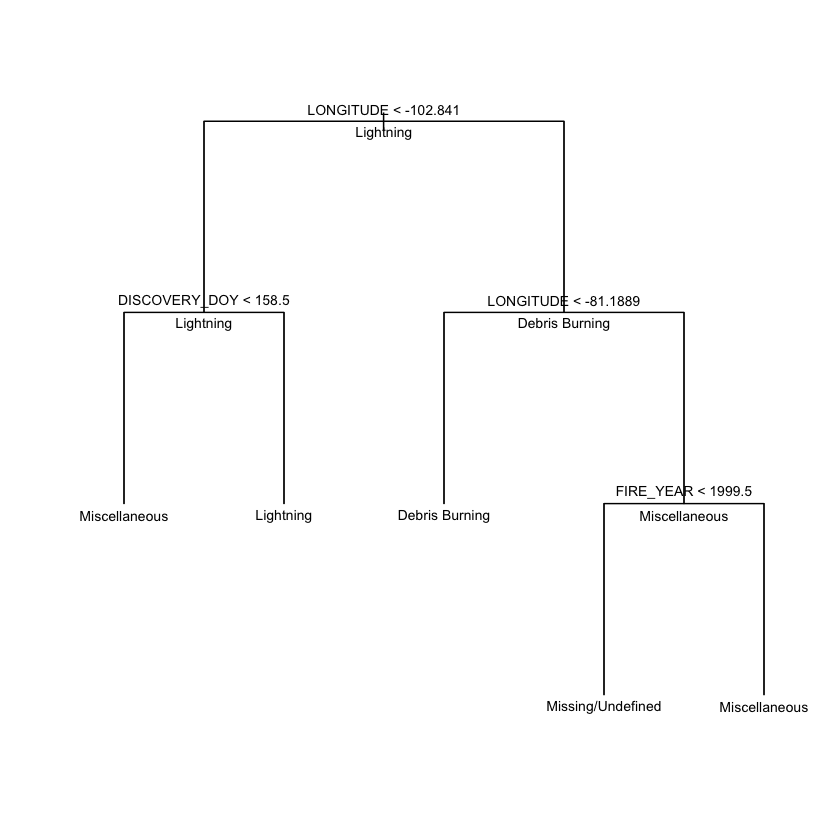

In [7]:
library(tree)
suppressMessages(library(tidymodels))
set.seed(111)

tree_fit <- tree(STAT_CAUSE_DESCR ~ ., data = train_set15)

plot(tree_fit, type = "uniform")
text(tree_fit, pretty = 1, all = TRUE, cex = 0.7)

In [23]:
tree_pred <- test_set15 %>% modelr::add_predictions(tree_fit, type = "class", var = 'EstCODE')

tree_pred %>% count(STAT_CAUSE_DESCR, EstCODE) %>% spread(STAT_CAUSE_DESCR,n)

EstCODE,Miscellaneous,Lightning,Debris Burning,Campfire,Equipment Use,Arson,Children,Railroad,Smoking,Powerline,Structure,Fireworks,Missing/Undefined
Miscellaneous,1041,307,504,195,166,333,88,23,115,32,10,7,206
Lightning,603,2867,184,524,289,239,106,27,132,30,6,74,239
Debris Burning,777,292,1969,170,349,1535,227,79,144,57,22,69,339
Missing/Undefined,10,4,41,7,11,38,14,3,9,5,NA,4,312


### Random Forest <a class="anchor" id="first-bullet"></a>


In [13]:
suppressMessages(library(randomForest))

set.seed(111)

rf_fit <- randomForest(STAT_CAUSE_DESCR ~ ., test_set15)
rf_pred <- test_set15 %>% mutate(EstCODE = predict(rf_fit, test_set15, type = 'class'))

mean(test_set15$STAT_CAUSE_DESCR != rf_pred$EstCODE)


[1] 0.001685318

In [40]:
rf_pred %>% count(STAT_CAUSE_DESCR, EstCODE) %>% spread(STAT_CAUSE_DESCR,n) %>% prop.table(margin = 1) %>% as.data.frame.matrix()

ERROR: Error in margin.table(x, margin): 'x' is not an array
